# 4.2 Open-loop Evaluation

### Load ground truths and predictions

In [1]:
import os
# do we have the correct env loaded?
assert 'donkey' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [2]:
import numpy as np
fast_model_fast_data_3d = np.load('open-loop-results/nighttime-fast-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')
fast_model_slow_data_3d = np.load('open-loop-results/nighttime-fast-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')
slow_model_fast_data_3d = np.load('open-loop-results/nighttime-slow-auto-3d-model-nighttime-fast-auto-data-prediction-and-ground-truth.npy')
slow_model_slow_data_3d = np.load('open-loop-results/nighttime-slow-auto-3d-model-nighttime-slow-auto-data-prediction-and-ground-truth.npy')
fast_model_fast_data_linear = np.loadtxt('open-loop-results/nighttime-fast-auto-linear-model-nighttime-fast-auto-data-prediction-and-ground-truth.csv.gz')
fast_model_slow_data_linear = np.loadtxt('open-loop-results/nighttime-fast-auto-linear-model-nighttime-slow-auto-data-prediction-and-ground-truth.csv.gz')
slow_model_fast_data_linear = np.loadtxt('open-loop-results/nighttime-slow-auto-linear-model-nighttime-fast-auto-data-prediction-and-ground-truth.csv.gz')
slow_model_slow_data_linear = np.loadtxt('open-loop-results/nighttime-slow-auto-linear-model-nighttime-slow-auto-data-prediction-and-ground-truth.csv.gz')


In [3]:
preds_and_ground_truths = dict(
    fast_fast_3d=fast_model_fast_data_3d,
    slow_fast_3d=slow_model_fast_data_3d,
    fast_fast_linear=fast_model_fast_data_linear,
    slow_fast_linear=slow_model_fast_data_linear,
    fast_slow_3d=fast_model_slow_data_3d,
    slow_slow_3d=slow_model_slow_data_3d,
    fast_slow_linear=fast_model_slow_data_linear,
    slow_slow_linear=slow_model_slow_data_linear,
)

### Arrange the ground truths and test set predictions into a Pandas Dataframe for easier analysis

In [6]:
import pandas as pd

records = []

for name, data in preds_and_ground_truths.items():
    model_speed = name.split('_')[0]
    model_type = name.split('_')[2]
    data_speed = name.split('_')[1]
    for (gt, pred) in zip(data[:, data.shape[1] - 1], data[:, data.shape[1] - 2]):
        dd = dict()
        dd['model speed'] = model_speed
        dd['model type'] = model_type
        dd['data speed'] = data_speed
        dd['ground_truth_angle'] = gt
        dd['predicted_angle'] = pred
        records.append(dd)
df = pd.DataFrame.from_records(records)

df.to_csv('open-loop-results/gt_and_preds.csv.gz')
df

,model speed,model type,data speed,ground_truth_angle,predicted_angle
0,fast,3d,fast,0.034974,0.452513
1,fast,3d,fast,0.043523,0.473522
2,fast,3d,fast,0.043523,0.482327
3,fast,3d,fast,0.071512,0.474770
4,fast,3d,fast,0.098842,0.491792
...,...,...,...,...,...
158251,slow,linear,slow,0.095727,0.048836
158252,slow,linear,slow,0.109439,0.068060
158253,slow,linear,slow,0.127183,0.073969
158254,slow,linear,slow,0.115749,0.068338


In [15]:
import pandas as pd

df = pd.read_csv('open-loop-results/gt_and_preds.csv.gz', index_col=0)

In [16]:
df['mean absolute error'] = abs(df.predicted_angle - df.ground_truth_angle)
df = df.drop(columns=['ground_truth_angle', 'predicted_angle'])

### Table 1 in Chapter 4.2 Open-loop evaluation

In [19]:
df[df['model type']=='linear'].groupby(['model speed', 'model type', 'data speed']).mean()

mean absolute error
model speed model type data speed                     
fast        linear     fast                   0.023740
                       slow                   0.026628
slow        linear     fast                   0.047309
                       slow                   0.023205

### Table 2 in Chapter 4.2 Open-loop evaluation


In [26]:
df[df['model type']=='3d'].groupby(['model speed', 'model type', 'data speed']).mean()

mean absolute error
model speed model type data speed                     
fast        3d         fast                   0.061224
                       slow                   0.061423
slow        3d         fast                   0.129813
                       slow                   0.088841

### Table 3 in Chapter 4.2 Open-loop evaluation


In [29]:
[
('single-frame known', float(df[df['model type']=='linear'][df['model speed'] == df['data speed']].mean()), ),
('single-frame novel', float(df[df['model type']=='linear'][df['model speed'] != df['data speed']].mean()), ),
('multi-frame known', float(df[df['model type']=='3d'][df['model speed'] == df['data speed']].mean()), ),
('multi-frame novel', float(df[df['model type']=='3d'][df['model speed'] != df['data speed']].mean()), ),
]


/Users/kristjan.roosild/opt/miniconda3/envs/donkey2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/kristjan.roosild/opt/miniconda3/envs/donkey2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kristjan.roosild/opt/miniconda3/envs/donkey2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/kristjan.roosild/opt/miniconda3/envs/donkey2/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


[('single-frame known', 0.02346547094792242),
 ('single-frame novel', 0.03669640507885856),
 ('multi-frame known', 0.07540050935184402),
 ('multi-frame novel', 0.09470661164720932)]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl


def plot_gt_and_pred(tub_preds_and_ground_truths):
    fig, axs = plt.subplots(nrows=len(tub_preds_and_ground_truths), ncols=1, figsize=(10, 5), sharex='all', sharey='all')
    for i, (name, data) in enumerate(tub_preds_and_ground_truths.items()):
        ax = axs.flat[i]
        ax.grid(True, axis='y')

        gt = data[0:2000, data.shape[1]-1]
        ax.plot(gt, label='ground truth', color='saddlebrown')

        preds = data[0:2000, data.shape[1]-2]
        ax.plot(preds, label='prediction', color='sandybrown')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.grid(True, axis='y')
        ax.tick_params(axis='y', colors=mpl.rcParams['grid.color'])
        if i == 0:
            ax.set(title=name, ylabel='angle')
        if i == 1:
            ax.legend()
            ax.set(title=name, ylabel='angle', xlabel='frame number')
    fig.tight_layout()
    plt.show()



### Figure 12.
Comparison of ground truth and predicted angles of a multi-frame model trained on fast data.


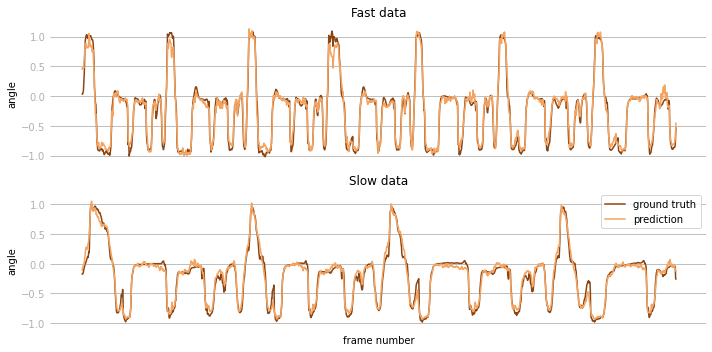

In [33]:


tub_preds_and_ground_truths = {
    'Fast data': fast_model_fast_data_3d,
    'Slow data': fast_model_slow_data_3d,
}
plot_gt_and_pred(tub_preds_and_ground_truths)


### Figure 13.
Comparison of ground truth and predicted angles of a multi-frame model trained on slow data.


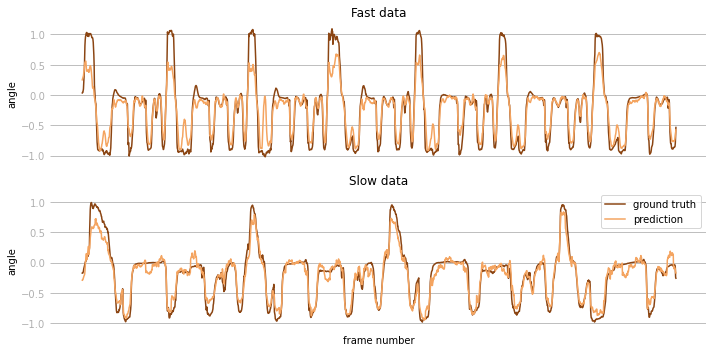

In [34]:

tub_preds_and_ground_truths = {
    'Fast data': slow_model_fast_data_3d,
    'Slow data': slow_model_slow_data_3d,
}
plot_gt_and_pred(tub_preds_and_ground_truths)
